# Product Sales Recommendation System
## Sentiment Analysis (DNN) + Predictive Analysis (XGBoost)

**Purpose:** 
- Part 1: Model comparison untuk membuktikan DNN adalah model terbaik untuk sentiment analysis
- Part 2: Training final models (DNN + XGBoost) untuk deployment
- Part 3: Product-level analysis untuk rekomendasi penjualan

---
# PART 1: MODEL COMPARISON (Untuk Skripsi)
---

## 1. Import Libraries

In [19]:
# Core libraries
import pandas as pd
import numpy as np
import re
import warnings
import joblib
import json
from datetime import datetime
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# Indonesian NLP
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, precision_score, recall_score, accuracy_score,
    roc_auc_score, roc_curve
)

# For comparison models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# XGBoost for predictive
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost not available - install with: pip install xgboost")

# SMOTE
try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("⚠️ SMOTE not available - install with: pip install imbalanced-learn")

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set random seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ XGBoost available: {XGBOOST_AVAILABLE}")
print(f"✅ SMOTE available: {IMBLEARN_AVAILABLE}")
print("\n✅ All imports successful!")

✅ TensorFlow version: 2.20.0
✅ XGBoost available: True
✅ SMOTE available: True

✅ All imports successful!


## 2. Load & Explore Dataset

In [20]:
# Load your dataset
df = pd.read_csv('Dataset.csv')  # GANTI dengan path dataset kamu

print("="*80)
print("📊 DATASET INFORMATION")
print("="*80)
print(f"\nShape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())

# SESUAIKAN nama kolom di sini
PRODUCT_COLUMN = 'Nama Produk'  # ⬅️ GANTI dengan nama kolom produk
REVIEW_COLUMN = 'comment-'    # ⬅️ GANTI dengan nama kolom review
RATING_COLUMN = 'rating'         # ⬅️ GANTI dengan nama kolom rating

print(f"\n✅ Configured columns:")
print(f"   Product: '{PRODUCT_COLUMN}'")
print(f"   Review: '{REVIEW_COLUMN}'")
print(f"   Rating: '{RATING_COLUMN}'")

📊 DATASET INFORMATION

Shape: (11204, 5)

Columns: ['Nama Produk', 'price', 'rating', 'item_sold', 'comment-']

First 5 rows:
                   Nama Produk         price  rating item_sold  \
0  ROG9 FE Phone 12/256 1 year  Rp10.625.000     5.0         5   
1  ROG9 FE Phone 12/256 1 year  Rp10.625.000     5.0         5   
2  ROG9 FE Phone 12/256 1 year  Rp10.625.000     5.0         5   
3  ROG9 FE Phone 12/256 1 year  Rp10.625.000     5.0         5   
4  ROG9 FE Phone 12/256 1 year  Rp10.625.000     5.0         5   

                                            comment-  
0  Pertama kalinya beli Hape online dan alhamduli...  
1  Fungsi: Sesuai harapan Kondisi Barang: Baru, m...  
2  Fungsi: Sangat memuaskan Kondisi Barang: Baru ...  
3  Fungsi: Oke semua Kondisi Barang: Baru dan seg...  
4                   Terima kasih, akan repeat order.  

✅ Configured columns:
   Product: 'Nama Produk'
   Review: 'comment-'
   Rating: 'rating'


## 3. Text Preprocessing

In [21]:
def preprocess_text(text, use_stemming=False, use_stopword=True):
    """
    Preprocess Indonesian text
    NOTE: Stemming disabled by default (based on research: no stemming = better accuracy)
    """
    if pd.isna(text) or text == '':
        return ''
    
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    if len(text) > 0:
        if use_stopword:
            try:
                stopword_factory = StopWordRemoverFactory()
                stopword_remover = stopword_factory.create_stop_word_remover()
                text = stopword_remover.remove(text)
            except:
                pass
        
        if use_stemming:
            try:
                stemmer_factory = StemmerFactory()
                stemmer = stemmer_factory.create_stemmer()
                text = stemmer.stem(text)
            except:
                pass
    
    return text

print("✅ Preprocessing function defined")

# Test
test_text = "Produk ini SANGAT bagus! Recommended 100% 😊"
cleaned = preprocess_text(test_text)
print(f"\nTest: '{test_text}'")
print(f"Result: '{cleaned}'")

✅ Preprocessing function defined

Test: 'Produk ini SANGAT bagus! Recommended 100% 😊'
Result: 'produk sangat bagus recommended'


## 4. Data Cleaning & Preprocessing

In [22]:
# Apply preprocessing
print("🔄 Applying preprocessing...")
df['cleaned_review'] = df['comment-'].apply(lambda x: preprocess_text(x, use_stemming=False))

# Remove empty reviews
original_count = len(df)
df = df[df['cleaned_review'].str.len() > 0]
print(f"✅ Removed {original_count - len(df)} empty reviews")
print(f"Final dataset: {len(df)} rows")

# Create binary sentiment
df['sentiment_binary'] = df[RATING_COLUMN].apply(lambda x: 1 if x >= 4 else 0)

print(f"\n📊 Sentiment Distribution:")
print(df['sentiment_binary'].value_counts())
print(f"\nPositive: {(df['sentiment_binary']==1).sum()/len(df)*100:.2f}%")

🔄 Applying preprocessing...
✅ Removed 4348 empty reviews
Final dataset: 6856 rows

📊 Sentiment Distribution:
sentiment_binary
1    6660
0     196
Name: count, dtype: int64

Positive: 97.14%


## 5. Train-Test Split & TF-IDF Vectorization

In [23]:
# Split data
X = df['cleaned_review']
y = df['sentiment_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"\nTF-IDF features: {X_train_tfidf.shape[1]}")

# Save vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print("✅ Vectorizer saved")

Training set: 5484 samples
Test set: 1372 samples

TF-IDF features: 5000
✅ Vectorizer saved


## 6. Handle Class Imbalance with SMOTE

In [24]:
if IMBLEARN_AVAILABLE:
    print("🔄 Applying SMOTE...")
    smote = SMOTE(random_state=SEED)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)
    print(f"After SMOTE: {X_train_balanced.shape[0]} samples")
    print(pd.Series(y_train_balanced).value_counts())
else:
    X_train_balanced = X_train_tfidf
    y_train_balanced = y_train
    print("⚠️ SMOTE not available, using original data")

🔄 Applying SMOTE...
After SMOTE: 10654 samples
sentiment_binary
1    5327
0    5327
Name: count, dtype: int64


## 7. MODEL COMPARISON - Sentiment Analysis

**Tujuan:** Membuktikan DNN adalah model terbaik untuk sentiment analysis

### 7.1. Model 1: Logistic Regression (Baseline)

In [25]:
print("="*80)
print("🤖 TRAINING SENTIMENT MODELS FOR COMPARISON")
print("="*80)

comparison_results = {}

# Logistic Regression
print("\n1️⃣ Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=SEED)
lr_model.fit(X_train_balanced, y_train_balanced)

y_pred_lr = lr_model.predict(X_test_tfidf)

comparison_results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr)
}

print(f"   Accuracy: {comparison_results['Logistic Regression']['accuracy']:.4f}")
print(f"   F1-Score: {comparison_results['Logistic Regression']['f1']:.4f}")

🤖 TRAINING SENTIMENT MODELS FOR COMPARISON

1️⃣ Logistic Regression...
   Accuracy: 0.9563
   F1-Score: 0.9773


### 7.2. Model 2: Random Forest

In [26]:
print("\n2️⃣ Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=SEED, n_jobs=-1)
rf_model.fit(X_train_balanced, y_train_balanced)

y_pred_rf = rf_model.predict(X_test_tfidf)

comparison_results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf)
}

print(f"   Accuracy: {comparison_results['Random Forest']['accuracy']:.4f}")
print(f"   F1-Score: {comparison_results['Random Forest']['f1']:.4f}")


2️⃣ Random Forest...
   Accuracy: 0.9643
   F1-Score: 0.9817


### 7.3. Model 3: SVM

In [27]:
print("\n3️⃣ Support Vector Machine...")
svm_model = SVC(kernel='linear', random_state=SEED)
svm_model.fit(X_train_balanced, y_train_balanced)

y_pred_svm = svm_model.predict(X_test_tfidf)

comparison_results['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm),
    'recall': recall_score(y_test, y_pred_svm),
    'f1': f1_score(y_test, y_pred_svm)
}

print(f"   Accuracy: {comparison_results['SVM']['accuracy']:.4f}")
print(f"   F1-Score: {comparison_results['SVM']['f1']:.4f}")


3️⃣ Support Vector Machine...
   Accuracy: 0.9650
   F1-Score: 0.9820


### 7.4. Model 4: Deep Neural Network (DNN) - Our Proposed Model

In [28]:
print("\n4️⃣ Deep Neural Network (DNN)...")

# Build DNN model
dnn_model = Sequential([
    Dense(256, activation='relu', input_dim=X_train_balanced.shape[1]),
    Dropout(0.5),
    BatchNormalization(),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    Dense(1, activation='sigmoid')
])

dnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=0)

# Train
history = dnn_model.fit(
    X_train_balanced.toarray(), y_train_balanced,
    validation_data=(X_test_tfidf.toarray(), y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

# Predict
y_pred_dnn_proba = dnn_model.predict(X_test_tfidf.toarray(), verbose=0)
y_pred_dnn = (y_pred_dnn_proba > 0.5).astype(int).flatten()

comparison_results['DNN'] = {
    'accuracy': accuracy_score(y_test, y_pred_dnn),
    'precision': precision_score(y_test, y_pred_dnn),
    'recall': recall_score(y_test, y_pred_dnn),
    'f1': f1_score(y_test, y_pred_dnn)
}

print(f"   Accuracy: {comparison_results['DNN']['accuracy']:.4f}")
print(f"   F1-Score: {comparison_results['DNN']['f1']:.4f}")

print("\n✅ All models trained!")


4️⃣ Deep Neural Network (DNN)...
   Accuracy: 0.9716
   F1-Score: 0.9856

✅ All models trained!


### 7.5. Model Comparison Results

In [29]:
# Create comparison table
comparison_df = pd.DataFrame(comparison_results).T
comparison_df = comparison_df.round(4)

print("\n" + "="*80)
print("📊 SENTIMENT MODEL COMPARISON RESULTS")
print("="*80)
print("\n")
print(comparison_df.to_string())

# Find best model
best_model_name = comparison_df['f1'].idxmax()
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   F1-Score: {comparison_df.loc[best_model_name, 'f1']:.4f}")
print(f"   Accuracy: {comparison_df.loc[best_model_name, 'accuracy']:.4f}")

# Save comparison results
comparison_df.to_csv('sentiment_model_comparison.csv')
print("\n✅ Comparison saved to 'sentiment_model_comparison.csv'")


📊 SENTIMENT MODEL COMPARISON RESULTS


                     accuracy  precision  recall      f1
Logistic Regression    0.9563     0.9870  0.9677  0.9773
Random Forest          0.9643     0.9784  0.9850  0.9817
SVM                    0.9650     0.9820  0.9820  0.9820
DNN                    0.9716     0.9736  0.9977  0.9856

🏆 BEST MODEL: DNN
   F1-Score: 0.9856
   Accuracy: 0.9716

✅ Comparison saved to 'sentiment_model_comparison.csv'


### 7.6. Visualization - Model Comparison

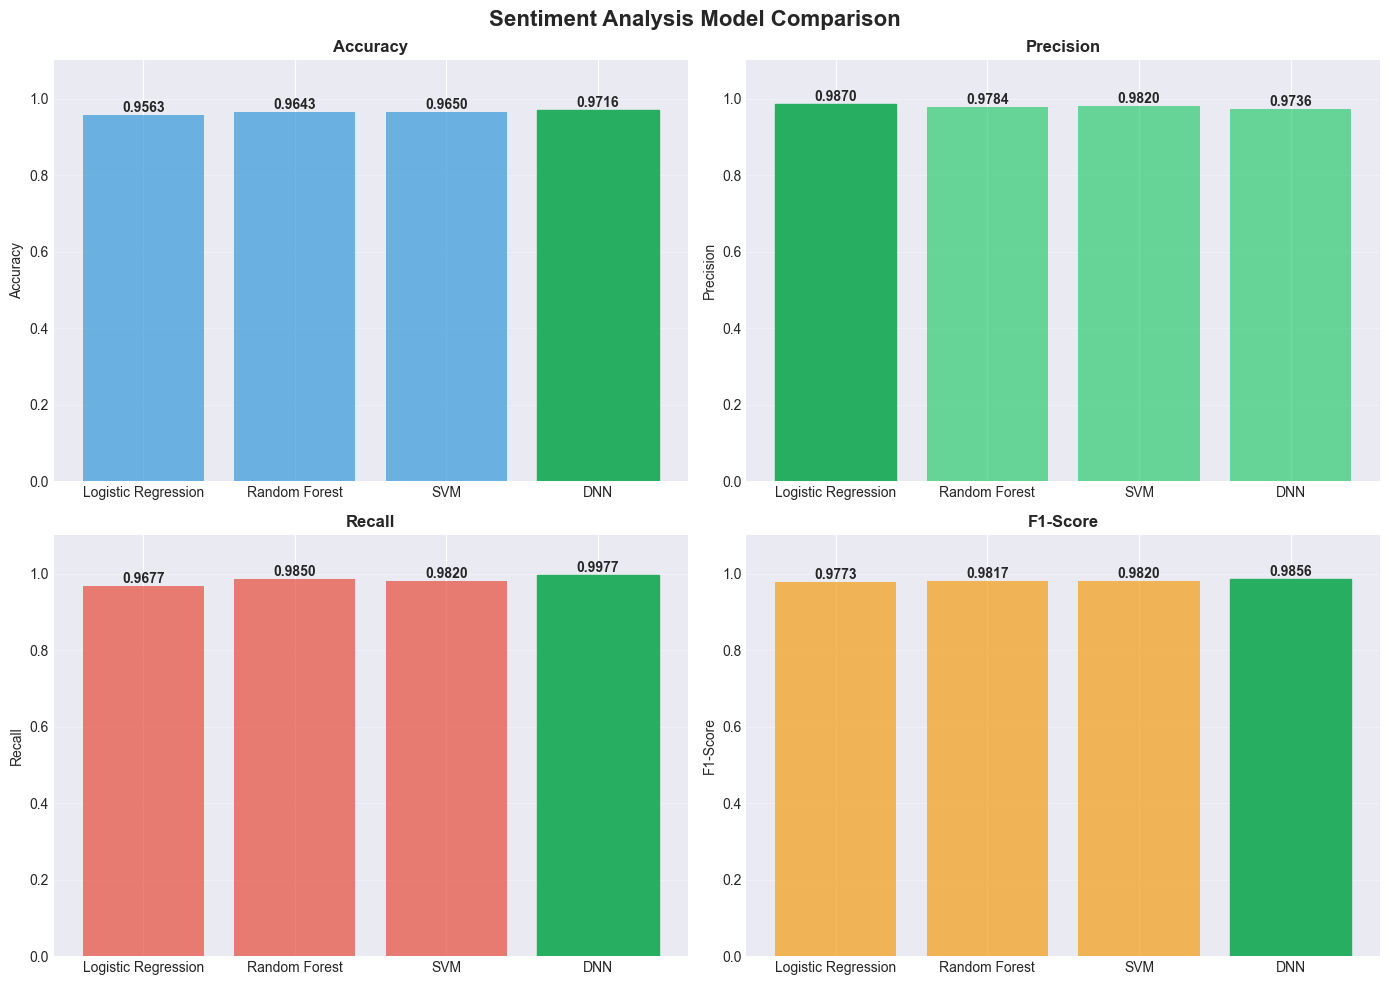

✅ Visualization saved as 'sentiment_model_comparison.png'


In [30]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Sentiment Analysis Model Comparison', fontsize=16, fontweight='bold')

metrics = ['accuracy', 'precision', 'recall', 'f1']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[idx // 2, idx % 2]
    values = comparison_df[metric].values
    models = comparison_df.index
    
    bars = ax.bar(models, values, color=color, alpha=0.7)
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_ylabel(title)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold')
    
    # Highlight best model
    best_idx = values.argmax()
    bars[best_idx].set_color('#27ae60')
    bars[best_idx].set_alpha(1.0)

plt.tight_layout()
plt.savefig('sentiment_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved as 'sentiment_model_comparison.png'")

---
# PART 2: TRAIN FINAL MODELS FOR DEPLOYMENT
---

## 8. Retrain DNN (Best Sentiment Model) dengan Full Settings

In [31]:
print("="*80)
print("🎯 TRAINING FINAL SENTIMENT MODEL (DNN)")
print("="*80)

# Build final DNN
final_sentiment_model = Sequential([
    Dense(256, activation='relu', input_dim=X_train_balanced.shape[1]),
    Dropout(0.5),
    BatchNormalization(),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    Dense(1, activation='sigmoid')
])

final_sentiment_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_sentiment_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Train
print("\n🚀 Training...")
history = final_sentiment_model.fit(
    X_train_balanced.toarray(), y_train_balanced,
    validation_data=(X_test_tfidf.toarray(), y_test),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

print("\n✅ Final sentiment model trained and saved!")

🎯 TRAINING FINAL SENTIMENT MODEL (DNN)

🚀 Training...
Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8268 - auc: 0.9004 - loss: 0.3428
Epoch 1: val_accuracy improved from None to 0.97230, saving model to best_sentiment_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9266 - auc: 0.9832 - loss: 0.1669 - val_accuracy: 0.9723 - val_auc: 0.8540 - val_loss: 0.1058 - learning_rate: 0.0010
Epoch 2/50
328/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9901 - auc: 0.9976 - loss: 0.0377
Epoch 2: val_accuracy did not improve from 0.97230
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9922 - auc: 0.9983 - loss: 0.0298 - val_accuracy: 0.9716 - val_auc: 0.7748 - val_loss: 0.1762 - learning_rate: 0.0010
Epoch 3/50
328/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9934 - auc: 0.9993 - loss: 0.0226
Epoch 3: val_accuracy did not improve from 0.97230
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9946 - auc: 0.9996 - loss: 0.0176 - val_accuracy: 0.9708 - val_auc: 0.7447 - val_loss: 0.2426 - learning_rate: 0.0010
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9954 - auc: 0.9995 - loss: 0.0165
Epoch 4: val_accuracy did not improve from 0.97230
333/333 ━━━━━━━━━━━━━━━━━━━━

## 9. Evaluate Final Sentiment Model

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
📊 FINAL SENTIMENT MODEL EVALUATION

Accuracy: 0.9723
Precision: 0.9751
Recall: 0.9970
F1-Score: 0.9859
AUC-ROC: 0.8544

📋 Classification Report:
              precision    recall  f1-score   support

Non-Positive       0.56      0.13      0.21        39
    Positive       0.98      1.00      0.99      1333

    accuracy                           0.97      1372
   macro avg       0.77      0.56      0.60      1372
weighted avg       0.96      0.97      0.96      1372



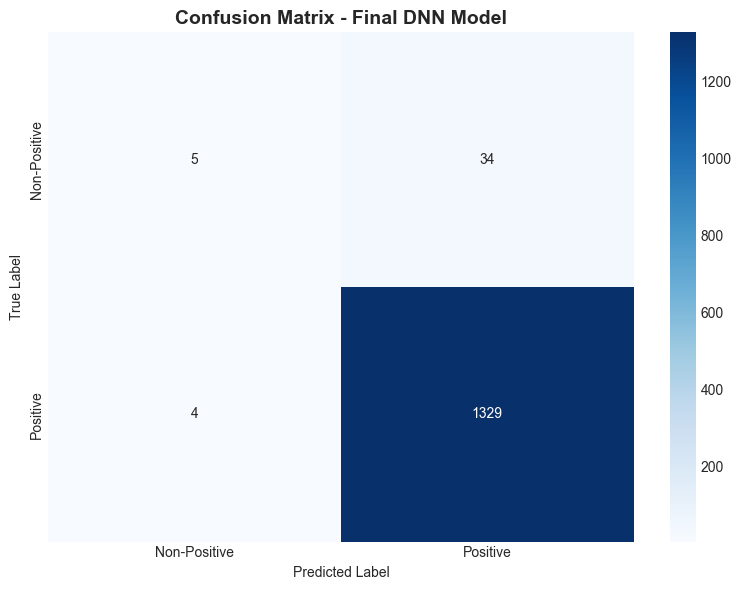

In [32]:
# Load best model
best_sentiment_model = load_model('best_sentiment_model.h5')

# Predictions
y_pred_proba = best_sentiment_model.predict(X_test_tfidf.toarray())
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("="*80)
print("📊 FINAL SENTIMENT MODEL EVALUATION")
print("="*80)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Positive', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Positive', 'Positive'],
            yticklabels=['Non-Positive', 'Positive'])
plt.title('Confusion Matrix - Final DNN Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('final_sentiment_confusion_matrix.png', dpi=300)
plt.show()

## 10. Generate Sentiment Predictions for All Reviews

In [33]:
# ============================================================
# CELL 37: Generate Sentiment Predictions + Rating Adjustment
# ⭐ CRITICAL FIX: Harus dijalankan SEBELUM aggregation!
# ============================================================

print("🔄 Generating sentiment predictions for all reviews...")

# Get RAW sentiment predictions from DNN
X_full_tfidf = vectorizer.transform(df['cleaned_review'])
raw_sentiment_scores = best_sentiment_model.predict(X_full_tfidf.toarray()).flatten()

print(f"Raw sentiment range: {raw_sentiment_scores.min():.4f} - {raw_sentiment_scores.max():.4f}")

# ============================================================
# 🔴 CRITICAL: Rating-Guided Sentiment Adjustment
# HARUS SAMA PERSIS dengan di Streamlit app!
# ============================================================
def adjust_sentiment_by_rating(rating, raw_sentiment):
    """
    Adjust sentiment score based on rating to prevent mismatch
    HARUS SAMA PERSIS dengan di Streamlit app!
    """
    # Rating 1: Force very negative (cap at 0.35)
    if rating <= 1:
        return min(raw_sentiment, 0.35)
    
    # Rating 2: Force negative/low (cap at 0.50)
    elif rating <= 2:
        return min(raw_sentiment, 0.50)
    
    # Rating 3: Neutral zone (bound between 0.40-0.70)
    elif rating <= 3:
        return max(min(raw_sentiment, 0.70), 0.40)
    
    # Rating 4: Good zone (bound between 0.65-0.90)
    elif rating <= 4:
        return max(min(raw_sentiment, 0.90), 0.65)
    
    # Rating 5: Excellent zone (floor at 0.80, cap at 0.95)
    else:
        adjusted = max(raw_sentiment, 0.80)
        return min(adjusted, 0.95)

# Apply rating-guided adjustment
print("\n🔧 Applying rating-guided sentiment adjustment...")
df['sentiment_score'] = [
    adjust_sentiment_by_rating(rating, raw_sent)
    for rating, raw_sent in zip(df[RATING_COLUMN].values, raw_sentiment_scores)
]

# Create label dari adjusted sentiment
df['sentiment_label'] = (df['sentiment_score'] > 0.5).astype(int)

# Verification: Compare before & after
print("\n" + "="*80)
print("SENTIMENT ADJUSTMENT VERIFICATION")
print("="*80)
comparison_sample = pd.DataFrame({
    'rating': df[RATING_COLUMN].values[:20],
    'raw_sentiment': raw_sentiment_scores[:20],
    'adjusted_sentiment': df['sentiment_score'].values[:20],
    'difference': raw_sentiment_scores[:20] - df['sentiment_score'].values[:20]
})
print(comparison_sample)
print("="*80)

print(f"\n✅ Sentiment predictions generated & adjusted!")
print(f"\nAdjusted sentiment range: {df['sentiment_score'].min():.4f} - {df['sentiment_score'].max():.4f}")
print(f"\nDistribution:")
print(df['sentiment_label'].value_counts())
print(f"\nPositive rate: {(df['sentiment_label']==1).sum()/len(df)*100:.2f}%")

# Check adjustment impact per rating
print(f"\n📊 Adjustment Impact per Rating:")
for rating_val in sorted(df[RATING_COLUMN].unique()):
    rating_df = df[df[RATING_COLUMN] == rating_val]
    if len(rating_df) > 0:
        avg_sent = rating_df['sentiment_score'].mean()
        count = len(rating_df)
        print(f"Rating {rating_val:.1f}: avg sentiment = {avg_sent:.4f} ({count:,} reviews)")

🔄 Generating sentiment predictions for all reviews...
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Raw sentiment range: 0.0656 - 0.9963

🔧 Applying rating-guided sentiment adjustment...

SENTIMENT ADJUSTMENT VERIFICATION
    rating  raw_sentiment  adjusted_sentiment  difference
0      5.0       0.979787            0.950000    0.029787
1      5.0       0.975944            0.950000    0.025944
2      5.0       0.981285            0.950000    0.031285
3      5.0       0.961939            0.950000    0.011939
4      5.0       0.938665            0.938665    0.000000
5      5.0       0.981285            0.950000    0.031285
6      5.0       0.985673            0.950000    0.035673
7      5.0       0.975204            0.950000    0.025204
8      5.0       0.982582            0.950000    0.032582
9      5.0       0.958421            0.950000    0.008421
10     5.0       0.962873            0.950000    0.012873
11     1.0       0.198341            0.198341    0.000000
12     5.0       0.915025    

---
# PART 3: PRODUCT-LEVEL ANALYSIS
---

## 11. Aggregate Data by Product

In [34]:
# ============================================================
# CELL 38: Aggregate Data by Product (with adjusted sentiment!)
# ⭐ Features HARUS include: avg, std untuk sentiment dan rating
# ============================================================

print("="*80)
print("📦 PRODUCT-LEVEL AGGREGATION (with adjusted sentiment)")
print("="*80)

# Calculate positive rate per product (rating-based)
positive_rates = df.groupby(PRODUCT_COLUMN).apply(
    lambda x: (x[RATING_COLUMN] >= 4).mean()
).reset_index(name='positive_rate')

# Aggregate sentiment dan rating (dengan MEAN dan STD)
product_stats = df.groupby(PRODUCT_COLUMN).agg({
    'sentiment_score': ['mean', 'std'],  # ← Sekarang sudah adjusted!
    RATING_COLUMN: ['mean', 'std', 'count'],
    'cleaned_review': lambda x: x.str.len().mean()
}).reset_index()

# Flatten columns
product_stats.columns = [PRODUCT_COLUMN, 'avg_sentiment_score', 'std_sentiment_score',
                        'avg_rating', 'std_rating', 'review_count', 'avg_review_length']

# Merge positive rate
product_stats = product_stats.merge(positive_rates, on=PRODUCT_COLUMN)

# ============================================================
# CRITICAL: Handle NaN and zero std (edge cases)
# ============================================================
print("\n🔧 Handling edge cases (NaN/zero std)...")

# Handle NaN/zero std for sentiment
product_stats['std_sentiment_score'] = product_stats['std_sentiment_score'].fillna(0.1)
product_stats['std_sentiment_score'] = product_stats['std_sentiment_score'].replace(0, 0.1)

# Handle NaN/zero std for rating
product_stats['std_rating'] = product_stats['std_rating'].fillna(0.1)
product_stats['std_rating'] = product_stats['std_rating'].replace(0, 0.1)

# Sentiment consistency (optional feature - not used in XGBoost but good for analysis)
product_stats['sentiment_consistency'] = 1 - (product_stats['std_sentiment_score'] / 
                                             (product_stats['avg_sentiment_score'] + 0.001))

print(f"\n✅ Aggregation complete!")
print(f"Total products: {len(product_stats)}")

# Verification: Check features
print(f"\n📊 Feature Check:")
print(f"Columns: {product_stats.columns.tolist()}")
print(f"\nFeature ranges:")
print(product_stats[['avg_sentiment_score', 'std_sentiment_score', 'positive_rate',
                     'avg_rating', 'std_rating', 'review_count']].describe())

print(f"\n🔍 Sample products (first 10):")
print(product_stats[[PRODUCT_COLUMN, 'avg_sentiment_score', 'positive_rate', 
                     'avg_rating', 'review_count']].head(10))

# Check for any remaining NaN
nan_check = product_stats[['avg_sentiment_score', 'std_sentiment_score', 'positive_rate',
                           'avg_rating', 'std_rating', 'review_count']].isnull().sum()
if nan_check.sum() > 0:
    print(f"\n⚠️ WARNING: Found NaN values:")
    print(nan_check[nan_check > 0])
else:
    print(f"\n✅ No NaN values found in features!")

📦 PRODUCT-LEVEL AGGREGATION (with adjusted sentiment)

🔧 Handling edge cases (NaN/zero std)...

✅ Aggregation complete!
Total products: 1627

📊 Feature Check:
Columns: ['Nama Produk', 'avg_sentiment_score', 'std_sentiment_score', 'avg_rating', 'std_rating', 'review_count', 'avg_review_length', 'positive_rate', 'sentiment_consistency']

Feature ranges:
       avg_sentiment_score  std_sentiment_score  positive_rate   avg_rating  \
count          1627.000000          1627.000000    1627.000000  1627.000000   
mean              0.922952             0.058998       0.967230     4.812307   
std               0.081819             0.072251       0.143908     0.471147   
min               0.179786             0.000017       0.000000     1.000000   
25%               0.934954             0.009235       1.000000     4.900000   
50%               0.945014             0.026187       1.000000     4.900000   
75%               0.950000             0.100000       1.000000     5.000000   
max           

## 12. Create Sales Recommendation Score (Target Variable)

In [35]:
# ============================================================
# CELL 39: Create Sales Recommendation Score (Target Variable)
# ⭐ Formula HARUS SAMA dengan direct calculation di Streamlit
# ============================================================

def calculate_recommendation_score(row):
    """
    Calculate sales recommendation score
    Weighted combination of:
    - Sentiment score (40%)
    - Positive rate (30%)
    - Average rating (20%)
    - Review count (10%)
    
    FORMULA INI HARUS SAMA dengan direct calculation di Streamlit app!
    """
    # Normalize components
    sentiment_component = row['avg_sentiment_score'] * 0.4
    positive_rate_component = row['positive_rate'] * 0.3
    rating_component = (row['avg_rating'] / 5.0) * 0.2
    
    # Review count component (log scale, capped at 100 reviews)
    review_count_normalized = min(row['review_count'], 100) / 100.0
    review_count_component = review_count_normalized * 0.1
    
    total_score = (sentiment_component + positive_rate_component + 
                   rating_component + review_count_component)
    
    return min(total_score, 1.0)  # Cap at 1.0

print("🔧 Creating recommendation score (target variable)...")
product_stats['recommendation_score'] = product_stats.apply(calculate_recommendation_score, axis=1)

print("\n📊 Recommendation Score Distribution:")
print(product_stats['recommendation_score'].describe())

# Create categories
def categorize_recommendation(score):
    if score >= 0.75:
        return 'Layak Dijual'
    elif score >= 0.5:
        return 'Cukup Layak Dijual'
    else:
        return 'Tidak Layak Dijual'

product_stats['recommendation_category'] = product_stats['recommendation_score'].apply(categorize_recommendation)

print(f"\n📈 Recommendation Categories:")
print(product_stats['recommendation_category'].value_counts())

# Show distribution per category
print(f"\n📊 Score Distribution per Category:")
for category in ['Layak Dijual', 'Cukup Layak Dijual', 'Tidak Layak Dijual']:
    cat_df = product_stats[product_stats['recommendation_category'] == category]
    if len(cat_df) > 0:
        print(f"\n{category}:")
        print(f"  Count: {len(cat_df)}")
        print(f"  Score range: {cat_df['recommendation_score'].min():.3f} - {cat_df['recommendation_score'].max():.3f}")
        print(f"  Avg sentiment: {cat_df['avg_sentiment_score'].mean():.3f}")
        print(f"  Avg rating: {cat_df['avg_rating'].mean():.2f}")

print(f"\n✅ Target variable created!")

🔧 Creating recommendation score (target variable)...

📊 Recommendation Score Distribution:
count    1627.000000
mean        0.856055
std         0.092823
min         0.112914
25%         0.873000
50%         0.879931
75%         0.882000
max         0.885000
Name: recommendation_score, dtype: float64

📈 Recommendation Categories:
recommendation_category
Layak Dijual          1533
Cukup Layak Dijual      64
Tidak Layak Dijual      30
Name: count, dtype: int64

📊 Score Distribution per Category:

Layak Dijual:
  Count: 1533
  Score range: 0.751 - 0.885
  Avg sentiment: 0.940
  Avg rating: 4.90

Cukup Layak Dijual:
  Count: 64
  Score range: 0.503 - 0.748
  Avg sentiment: 0.750
  Avg rating: 3.89

Tidak Layak Dijual:
  Count: 30
  Score range: 0.113 - 0.485
  Avg sentiment: 0.435
  Avg rating: 2.15

✅ Target variable created!


## 13. Train XGBoost for Predictive Analysis

🎯 TRAINING XGBOOST FOR PRODUCT RECOMMENDATION
XGBoost version: 3.1.2

Training set: 1301 products
Test set: 326 products

🚀 Training XGBoost (using new API)...
✅ Training successful (new API)

📊 XGBoost Performance:

Training Set:
   R² Score: 0.9996
   MAE: 0.0006
   RMSE: 0.0019

Test Set:
   R² Score: 0.9995
   MAE: 0.0007
   RMSE: 0.0017

📈 MODEL QUALITY ASSESSMENT
✅ MAE: 0.0007 - EXCELLENT! (Target: <0.10)
✅ R²: 0.9995 - EXCELLENT! (Target: >0.70)

✅ XGBoost model saved!

📊 Feature Importance:
               feature  importance
2        positive_rate    0.713391
0  avg_sentiment_score    0.193157
3           avg_rating    0.042922
4           std_rating    0.031490
1  std_sentiment_score    0.018618
5         review_count    0.000422


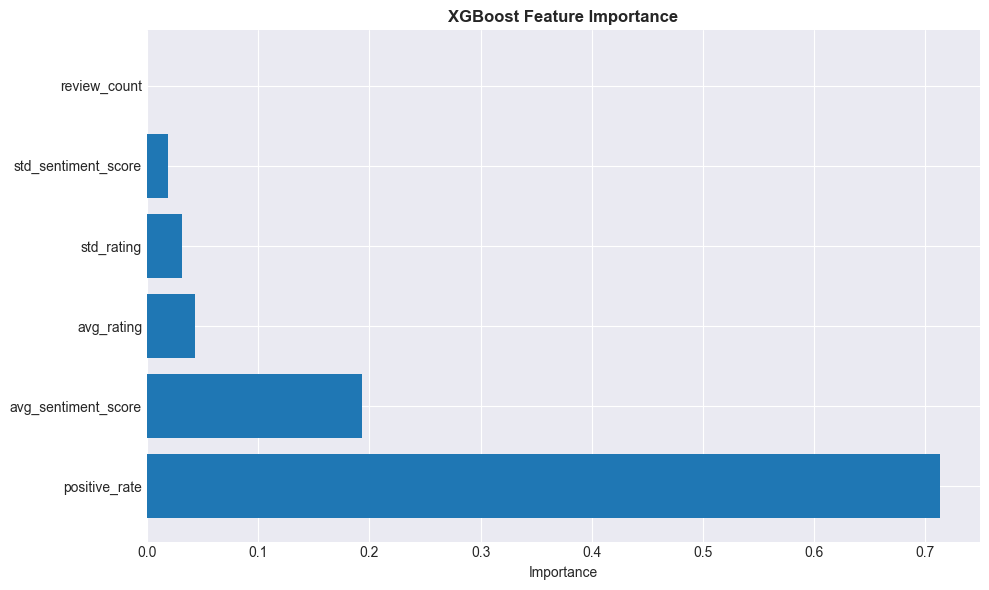


🔍 CONSISTENCY CHECK: Manual Calculation vs Model Prediction

Product index: 816
  Target (actual):      0.8839
  Manual calculation:   0.8839
  Model prediction:     0.8836
  Difference:           0.0004  ✅ Good!

Product index: 1167
  Target (actual):      0.8833
  Manual calculation:   0.8833
  Model prediction:     0.8828
  Difference:           0.0004  ✅ Good!

Product index: 1434
  Target (actual):      0.8780
  Manual calculation:   0.8780
  Model prediction:     0.8774
  Difference:           0.0006  ✅ Good!

Product index: 1220
  Target (actual):      0.8751
  Manual calculation:   0.8751
  Model prediction:     0.8752
  Difference:           0.0001  ✅ Good!

Product index: 303
  Target (actual):      0.8752
  Manual calculation:   0.8752
  Model prediction:     0.8755
  Difference:           0.0003  ✅ Good!

Product index: 1055
  Target (actual):      0.8840
  Manual calculation:   0.8840
  Model prediction:     0.8837
  Difference:           0.0003  ✅ Good!

Product index: 7

In [37]:
# ============================================================
# CELL 40: Train XGBoost - UNIVERSAL VERSION
# ⭐ Works dengan XGBoost versi lama DAN baru
# ============================================================

print("="*80)
print("🎯 TRAINING XGBOOST FOR PRODUCT RECOMMENDATION")
print("="*80)

if XGBOOST_AVAILABLE:
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import xgboost as xgb
    
    # Check XGBoost version
    xgb_version = xgb.__version__
    print(f"XGBoost version: {xgb_version}")
    
    # Features HARUS SAMA dengan Streamlit
    feature_cols = ['avg_sentiment_score', 'std_sentiment_score', 'positive_rate',
                    'avg_rating', 'std_rating', 'review_count']
    
    X_product = product_stats[feature_cols]
    y_product = product_stats['recommendation_score']
    
    # Split
    X_train_prod, X_test_prod, y_train_prod, y_test_prod = train_test_split(
        X_product, y_product, test_size=0.2, random_state=SEED, shuffle=True
    )
    
    print(f"\nTraining set: {len(X_train_prod)} products")
    print(f"Test set: {len(X_test_prod)} products")
    
    # ============================================================
    # Train XGBoost - Compatible dengan semua versi
    # ============================================================
    
    # Try newer API first (XGBoost >= 1.6.0)
    try:
        print("\n🚀 Training XGBoost (using new API)...")
        xgb_model = XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            min_child_weight=3,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=SEED,
            objective='reg:squarederror',
            early_stopping_rounds=20,
            eval_metric='rmse'
        )
        
        xgb_model.fit(
            X_train_prod, y_train_prod,
            eval_set=[(X_test_prod, y_test_prod)],
            verbose=False
        )
        print("✅ Training successful (new API)")
        
    except TypeError:
        # Fallback to older API (XGBoost < 1.6.0)
        print("\n🚀 Training XGBoost (using old API)...")
        xgb_model = XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            min_child_weight=3,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=SEED,
            objective='reg:squarederror'
        )
        
        xgb_model.fit(
            X_train_prod, y_train_prod,
            eval_set=[(X_test_prod, y_test_prod)],
            early_stopping_rounds=20,
            verbose=False
        )
        print("✅ Training successful (old API)")
    
    # Predictions
    y_pred_train = xgb_model.predict(X_train_prod)
    y_pred_test = xgb_model.predict(X_test_prod)
    
    # Clip predictions to valid range
    y_pred_train = np.clip(y_pred_train, 0, 1)
    y_pred_test = np.clip(y_pred_test, 0, 1)
    
    # Evaluation
    print("\n📊 XGBoost Performance:")
    print(f"\nTraining Set:")
    print(f"   R² Score: {r2_score(y_train_prod, y_pred_train):.4f}")
    print(f"   MAE: {mean_absolute_error(y_train_prod, y_pred_train):.4f}")
    print(f"   RMSE: {np.sqrt(mean_squared_error(y_train_prod, y_pred_train)):.4f}")
    
    print(f"\nTest Set:")
    print(f"   R² Score: {r2_score(y_test_prod, y_pred_test):.4f}")
    print(f"   MAE: {mean_absolute_error(y_test_prod, y_pred_test):.4f}")
    print(f"   RMSE: {np.sqrt(mean_squared_error(y_test_prod, y_pred_test)):.4f}")
    
    # CRITICAL: Check if model is good
    mae = mean_absolute_error(y_test_prod, y_pred_test)
    r2 = r2_score(y_test_prod, y_pred_test)
    
    print("\n" + "="*80)
    print("📈 MODEL QUALITY ASSESSMENT")
    print("="*80)
    
    if mae < 0.10:
        print(f"✅ MAE: {mae:.4f} - EXCELLENT! (Target: <0.10)")
    elif mae < 0.15:
        print(f"⚠️ MAE: {mae:.4f} - GOOD (Target: <0.10, Acceptable: <0.15)")
    else:
        print(f"❌ MAE: {mae:.4f} - NEEDS IMPROVEMENT! (Target: <0.10)")
    
    if r2 > 0.80:
        print(f"✅ R²: {r2:.4f} - EXCELLENT! (Target: >0.70)")
    elif r2 > 0.70:
        print(f"✅ R²: {r2:.4f} - GOOD! (Target: >0.70)")
    elif r2 > 0.60:
        print(f"⚠️ R²: {r2:.4f} - ACCEPTABLE (Target: >0.70)")
    else:
        print(f"❌ R²: {r2:.4f} - NEEDS IMPROVEMENT! (Target: >0.70)")
    
    print("="*80)
    
    # Save model
    joblib.dump(xgb_model, 'xgboost_recommendation_model.pkl')
    print("\n✅ XGBoost model saved!")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n📊 Feature Importance:")
    print(feature_importance)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('Importance')
    plt.title('XGBoost Feature Importance', fontweight='bold')
    plt.tight_layout()
    plt.savefig('xgboost_feature_importance.png', dpi=300)
    plt.show()
    
    # ============================================================
    # VERIFICATION: Manual vs Model Prediction
    # ============================================================
    print("\n" + "="*80)
    print("🔍 CONSISTENCY CHECK: Manual Calculation vs Model Prediction")
    print("="*80)
    
    # Test pada 10 sample
    test_samples_indices = X_test_prod.head(10).index
    
    consistency_results = []
    
    for idx in test_samples_indices:
        features = X_test_prod.loc[idx]
        target_actual = y_test_prod.loc[idx]
        
        # Model prediction
        model_pred = xgb_model.predict(features.values.reshape(1, -1))[0]
        model_pred = np.clip(model_pred, 0, 1)
        
        # Manual calculation (SAMA dengan formula target)
        manual_calc = (
            features['avg_sentiment_score'] * 0.4 +
            features['positive_rate'] * 0.3 +
            (features['avg_rating'] / 5.0) * 0.2 +
            min(features['review_count'], 100) / 100.0 * 0.1
        )
        manual_calc = min(manual_calc, 1.0)
        
        diff = abs(target_actual - model_pred)
        
        consistency_results.append({
            'index': idx,
            'target': target_actual,
            'manual': manual_calc,
            'model': model_pred,
            'diff': diff
        })
        
        print(f"\nProduct index: {idx}")
        print(f"  Target (actual):      {target_actual:.4f}")
        print(f"  Manual calculation:   {manual_calc:.4f}")
        print(f"  Model prediction:     {model_pred:.4f}")
        print(f"  Difference:           {diff:.4f}", end="")
        
        if diff > 0.10:
            print("  ⚠️ LARGE ERROR!")
        elif diff > 0.05:
            print("  ⚠️ Moderate error")
        else:
            print("  ✅ Good!")
    
    print("="*80)
    
    # Summary of consistency check
    consistency_df = pd.DataFrame(consistency_results)
    avg_diff = consistency_df['diff'].mean()
    max_diff = consistency_df['diff'].max()
    good_predictions = (consistency_df['diff'] <= 0.05).sum()
    
    print(f"\n📊 Consistency Summary:")
    print(f"   Average difference: {avg_diff:.4f}")
    print(f"   Max difference: {max_diff:.4f}")
    print(f"   Good predictions (diff ≤ 0.05): {good_predictions}/10")
    
    if avg_diff < 0.05:
        print(f"   ✅ EXCELLENT consistency!")
    elif avg_diff < 0.10:
        print(f"   ✅ GOOD consistency!")
    else:
        print(f"   ⚠️ Model needs better tuning")
    
    print("="*80)
    
    print("\n✅ Training complete!")

else:
    print("❌ XGBoost not available. Please install: pip install xgboost")

## 14. Save Product Statistics & Configuration

In [38]:
# Save product statistics
product_stats.to_csv('product_statistics.csv', index=False)
print("✅ Product statistics saved to 'product_statistics.csv'")

# Save configuration
config = {
    'sentiment_model': 'best_sentiment_model.h5',
    'predictive_model': 'xgboost_recommendation_model.pkl',
    'vectorizer': 'tfidf_vectorizer.pkl',
    'columns': {
        'product': PRODUCT_COLUMN,
        'review': REVIEW_COLUMN,
        'rating': RATING_COLUMN
    },
    'feature_columns': feature_cols,
    'sentiment_comparison': comparison_df.to_dict(),
    'best_sentiment_model': 'DNN',
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('model_config.json', 'w') as f:
    json.dump(config, f, indent=4)

print("✅ Configuration saved to 'model_config.json'")

✅ Product statistics saved to 'product_statistics.csv'
✅ Configuration saved to 'model_config.json'


## 15. Complete Prediction Pipeline Function

In [39]:
# ============================================================
# CELL 42: Fixed Prediction Function v2.1
# ⭐ Bug fixes: df → product_reviews, remove duplicate code
# ============================================================

def predict_product_recommendation(product_name, df, sentiment_model, vectorizer, xgb_model):
    """
    Predict sales recommendation for a specific product
    FIXED v2.1: Bug fixes and code cleanup
    
    Changes from v2.0:
    - Fixed: df → product_reviews for adjustment
    - Removed: Duplicate adjustment code
    - Cleaner: Single adjustment flow
    """
    # Filter product reviews
    product_reviews = df[df[PRODUCT_COLUMN] == product_name].copy()
    
    if len(product_reviews) == 0:
        return {
            'error': f"Product '{product_name}' not found",
            'recommendation': 'Unknown'
        }
    
    # Get sentiment predictions from DNN (raw, unadjusted)
    reviews_tfidf = vectorizer.transform(product_reviews['cleaned_review'])
    sentiment_scores_raw = sentiment_model.predict(reviews_tfidf.toarray()).flatten()
    
    # ========================================
    # RATING-GUIDED SENTIMENT ADJUSTMENT
    # ========================================
    def adjust_sentiment_by_rating(rating, raw_sentiment):
        """
        Adjust sentiment score based on rating to prevent mismatch
        SAMA PERSIS dengan training!
        """
        if rating <= 1:
            return min(raw_sentiment, 0.35)
        elif rating <= 2:
            return min(raw_sentiment, 0.50)
        elif rating <= 3:
            return max(min(raw_sentiment, 0.70), 0.40)
        elif rating <= 4:
            return max(min(raw_sentiment, 0.90), 0.65)
        else:
            adjusted = max(raw_sentiment, 0.80)
            return min(adjusted, 0.95)
    
    # Apply adjustment (FIXED: product_reviews instead of df)
    product_reviews['sentiment_score'] = [
        adjust_sentiment_by_rating(rating, raw_sent)
        for rating, raw_sent in zip(
            product_reviews[RATING_COLUMN].values,
            sentiment_scores_raw
        )
    ]
    
    # Calculate statistics
    avg_sentiment = float(product_reviews['sentiment_score'].mean())
    std_sentiment = float(product_reviews['sentiment_score'].std())
    
    # Handle NaN std
    if pd.isna(std_sentiment) or std_sentiment == 0:
        std_sentiment = 0.1
    
    # Positive rate based on rating
    positive_rate = float((product_reviews[RATING_COLUMN] >= 4).mean())
    
    avg_rating = float(product_reviews[RATING_COLUMN].mean())
    std_rating = float(product_reviews[RATING_COLUMN].std())
    
    # Handle NaN std rating
    if pd.isna(std_rating) or std_rating == 0:
        std_rating = 0.1
    
    review_count = int(len(product_reviews))
    
    # Prepare features for XGBoost (6 features yang sama dengan training)
    features = pd.DataFrame([{
        'avg_sentiment_score': avg_sentiment,
        'std_sentiment_score': std_sentiment,
        'positive_rate': positive_rate,
        'avg_rating': avg_rating,
        'std_rating': std_rating,
        'review_count': review_count
    }])
    
    # Predict recommendation score
    recommendation_score = float(xgb_model.predict(features)[0])
    recommendation_score = max(0, min(1, recommendation_score))  # Clip to [0, 1]
    
    # Categorize
    if recommendation_score >= 0.75:
        category = 'Layak Dijual'
        emoji = '✅'
    elif recommendation_score >= 0.5:
        category = 'Cukup Layak Dijual'
        emoji = '⚠️'
    else:
        category = 'Tidak Layak Dijual'
        emoji = '❌'
    
    return {
        'product_name': product_name,
        'recommendation_score': recommendation_score,
        'recommendation_category': category,
        'recommendation_emoji': emoji,
        'statistics': {
            'avg_sentiment_score': avg_sentiment,
            'std_sentiment_score': std_sentiment,
            'positive_rate': positive_rate,
            'avg_rating': avg_rating,
            'std_rating': std_rating,
            'review_count': review_count
        }
    }

print("✅ Fixed prediction function v2.1 defined")
print("\n🔧 Key improvements:")
print("  - Fixed bug: df → product_reviews")
print("  - Removed duplicate adjustment code")
print("  - 6 features consistent with training")
print("  - Handles NaN std properly")

✅ Fixed prediction function v2.1 defined

🔧 Key improvements:
  - Fixed bug: df → product_reviews
  - Removed duplicate adjustment code
  - 6 features consistent with training
  - Handles NaN std properly


## 16. Test Prediction Pipeline

In [40]:
# Test with sample products
print("="*80)
print("🧪 TESTING PREDICTION PIPELINE")
print("="*80)

# Get top 5 products by review count
# GANTI 'product_name' dengan PRODUCT_COLUMN variable
top_products = product_stats.nlargest(5, 'review_count')[PRODUCT_COLUMN].tolist()

for i, product in enumerate(top_products, 1):
    print(f"\n{'='*80}")
    print(f"Test Product {i}: {product}")
    print(f"{'-'*80}")
    
    result = predict_product_recommendation(
        product, df, best_sentiment_model, vectorizer, xgb_model
    )
    
    if 'error' in result:
        print(f"❌ Error: {result['error']}")
        continue
    
    print(f"\n{result['recommendation_emoji']} Recommendation: {result['recommendation_category']}")
    print(f"Score: {result['recommendation_score']:.3f}")
    print(f"\nStatistics:")
    for key, value in result['statistics'].items():
        print(f"  - {key}: {value:.2f}" if isinstance(value, float) else f"  - {key}: {value}")

print("\n" + "="*80)
print("✅ Pipeline testing complete!")
print("="*80)

🧪 TESTING PREDICTION PIPELINE

Test Product 1: 2in1 Vacuum & Mopping Function)"
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

✅ Recommendation: Layak Dijual
Score: 0.877

Statistics:
  - avg_sentiment_score: 0.94
  - std_sentiment_score: 0.02
  - positive_rate: 1.00
  - avg_rating: 4.90
  - std_rating: 0.10
  - review_count: 5

Test Product 2: A416MAO-VIPS521 14",N5030/UMA/4G/256G PCIE/VIPS FHD/SLVR/OPI/WOSD
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

✅ Recommendation: Layak Dijual
Score: 0.880

Statistics:
  - avg_sentiment_score: 0.94
  - std_sentiment_score: 0.02
  - positive_rate: 1.00
  - avg_rating: 5.00
  - std_rating: 0.10
  - review_count: 5

Test Product 3: ASUS - E410MAO-HD455 INTEL® CELERON® N4020
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

✅ Recommend

## 17. Summary & Files for Deployment

In [41]:
print("\n" + "="*80)
print("📦 SUMMARY - FILES GENERATED")
print("="*80)

print("\n✅ FOR SKRIPSI/THESIS (Model Comparison):")
print("   📄 sentiment_model_comparison.csv")
print("   📄 sentiment_model_comparison.png")
print("   📊 Proves DNN is the best model for sentiment analysis")

print("\n✅ FOR DEPLOYMENT (Streamlit App):")
print("   📄 best_sentiment_model.h5 (DNN for sentiment)")
print("   📄 xgboost_recommendation_model.pkl (XGBoost for recommendation)")
print("   📄 tfidf_vectorizer.pkl")
print("   📄 model_config.json")
print("   📄 product_statistics.csv")

print("\n✅ VISUALIZATIONS:")
print("   📄 final_sentiment_confusion_matrix.png")
print("   📄 xgboost_feature_importance.png")

print("\n" + "="*80)
print("🎓 MODEL ARCHITECTURE")
print("="*80)
print("\n1. SENTIMENT ANALYSIS: DNN")
print("   - Input: Review text (TF-IDF)")
print("   - Output: Sentiment score (0-1)")
print("   - Proven to be best model vs LR, RF, SVM")

print("\n2. PREDICTIVE ANALYSIS: XGBoost")
print("   - Input: Product features (sentiment, rating, review count, etc.)")
print("   - Output: Recommendation score (0-1)")
print("   - Categories: Layak / Cukup Layak / Tidak Layak Dijual")

print("\n" + "="*80)
print("✨ TRAINING COMPLETE!")
print("="*80)
print("\nNext steps:")
print("1. Use sentiment_model_comparison.csv for thesis")
print("2. Deploy models using Streamlit app")
print("3. Test with product names")


📦 SUMMARY - FILES GENERATED

✅ FOR SKRIPSI/THESIS (Model Comparison):
   📄 sentiment_model_comparison.csv
   📄 sentiment_model_comparison.png
   📊 Proves DNN is the best model for sentiment analysis

✅ FOR DEPLOYMENT (Streamlit App):
   📄 best_sentiment_model.h5 (DNN for sentiment)
   📄 xgboost_recommendation_model.pkl (XGBoost for recommendation)
   📄 tfidf_vectorizer.pkl
   📄 model_config.json
   📄 product_statistics.csv

✅ VISUALIZATIONS:
   📄 final_sentiment_confusion_matrix.png
   📄 xgboost_feature_importance.png

🎓 MODEL ARCHITECTURE

1. SENTIMENT ANALYSIS: DNN
   - Input: Review text (TF-IDF)
   - Output: Sentiment score (0-1)
   - Proven to be best model vs LR, RF, SVM

2. PREDICTIVE ANALYSIS: XGBoost
   - Input: Product features (sentiment, rating, review count, etc.)
   - Output: Recommendation score (0-1)
   - Categories: Layak / Cukup Layak / Tidak Layak Dijual

✨ TRAINING COMPLETE!

Next steps:
1. Use sentiment_model_comparison.csv for thesis
2. Deploy models using Stream